# Data Loading

In [165]:
import mne
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

In [2]:
ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 
            'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 
            'P1', 'Pz', 'P2', 'POz']

In [3]:
raw = mne.io.read_raw_gdf('./data/A01T.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])


Extracting EDF parameters from /home/seohyunseo/eeg_signal_processing_v2/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/seohyunseo/.conda/envs/h_shs/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MB, data loaded>

In [4]:
raw_eog = mne.io.read_raw_gdf('./data/A01T.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)

Extracting EDF parameters from /home/seohyunseo/eeg_signal_processing_v2/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/seohyunseo/.conda/envs/h_shs/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [5]:
for i in range(len(ch_names)):
    raw.rename_channels({
        raw.info["ch_names"][i]: ch_names[i]
    })

In [6]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MB, data loaded>

# Raw Data visualization

In [7]:
# fig = raw.plot(scalings='auto', show=True)

In [8]:
# Plot the power spectral density 
# fig = raw.compute_psd(fmax=60, picks=[0]).plot(picks="data", exclude="bads", amplitude=False)

# Preprocessing

In [9]:
from utils.visualization import plot_comparison

### Rereferencing

In [10]:
ref_ch = ['Cz'] # Change reference channel as you want
# Use the average of all channels as reference
ref_avr = "average"

# Conduct CAR (Common Average Reference)
raw_ref = raw.copy().set_eeg_reference(ref_channels=ref_avr)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### Epoching

In [11]:
events = mne.events_from_annotations(raw_ref)
events[0].shape

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(603, 3)

In [12]:
event_dict={
 'reject':1,
 'eye move':2,
 'eye open':3,
 'eye close':4,
 'new run':5,
 'new trial':6,
 'class 1':7,
 'class 2':8,
 'class 3':9,
 'class 4':10,
}

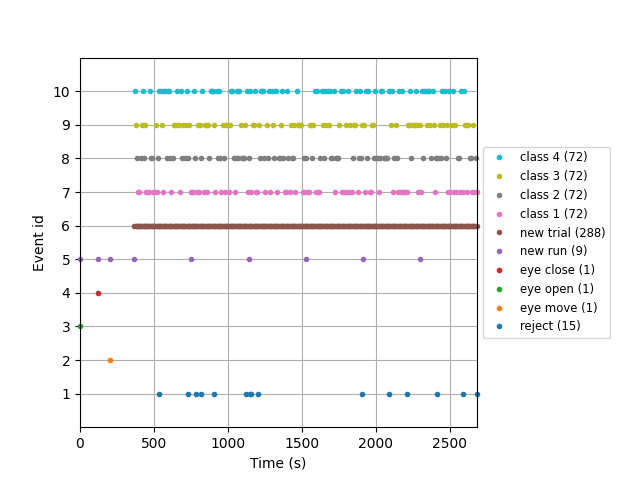

In [13]:
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw_ref.first_samp)

In [14]:
# Extracts epochs of 3s time period from the datset into 288 events for all 4 classes 
tmin = -1.
tmax = 2.
epochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True, baseline=None)

Not setting metadata
288 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 751 original time points ...
0 bad epochs dropped


In [15]:
'''
epochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True)
if baseline parameter isn't passed like above, then it is applied automatically 
'''
# Baseline correction
baseline = (None, 0)
epochs.apply_baseline(baseline)

Applying baseline correction (mode: mean)


<Epochs |  288 events (all good), -1 – 2 s, baseline -1 – 0 s, ~36.3 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>

Using matplotlib as 2D backend.


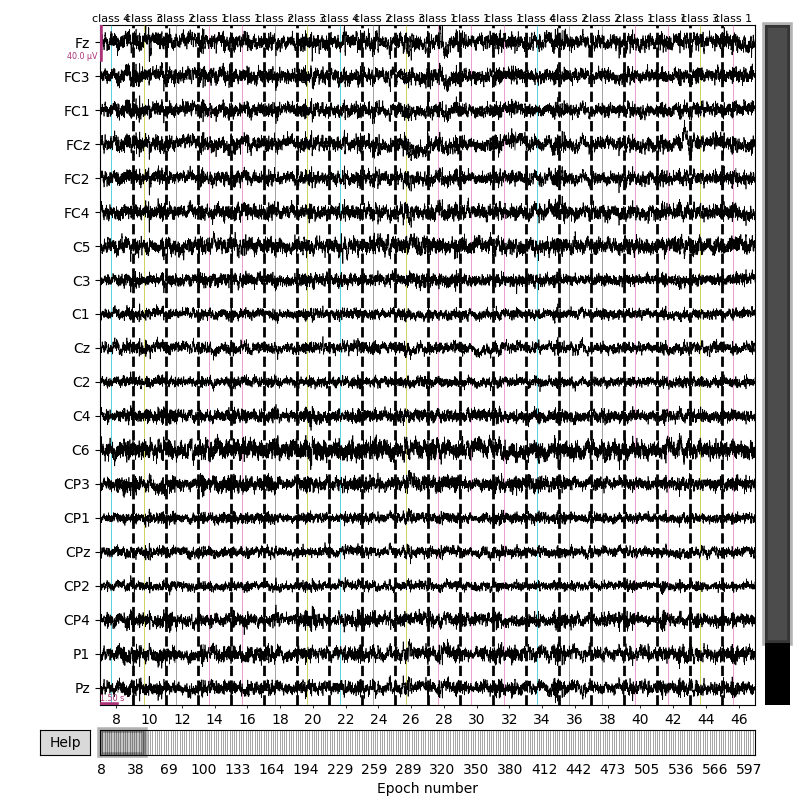

In [16]:
# Plot epoched data
fig = epochs.plot(events=events[0],
                  event_id=event_dict)

### Band-pass Filtering
0.05 - 50.0 Hz

In [17]:
# Filter the raw signal with a band pass filter in 0.5 - 50.0 Hz
l_freq = .05
h_freq = 50.0
epochs.filter(l_freq, h_freq, picks='eeg')

Setting up band-pass filter from 0.05 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 16501 samples (66.004 s)



/tmp/ipykernel_414855/675335079.py:4: RuntimeWarning: filter_length (16501) is longer than the signal (751), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, picks='eeg')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 3041 tasks  

<Epochs |  288 events (all good), -1 – 2 s, baseline -1 – 0 s, ~36.3 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>

In [18]:
# Plot power spectral density filtered data
# epochs.compute_psd(fmax=70).plot()

### Removing artifact with ICA

In [19]:
# Create ICA object first
ica_obj = mne.preprocessing.ICA(
                    n_components=0.99,
                    method='infomax',
                    max_iter="auto",
                    random_state=1,
                    fit_params=dict(extended=True))

In [20]:
ica_obj.fit(epochs)

Fitting ICA to data using 22 channels (please be patient, this may take a while)


/tmp/ipykernel_414855/1768247232.py:1: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica_obj.fit(epochs)


Selecting by explained variance: 15 components
Computing Extended Infomax ICA
Fitting ICA took 37.7s.


<ICA | epochs decomposition, method: infomax (fit in 192 iterations on 216288 samples), 15 ICA components (22 PCA components available), channel types: eeg, no sources marked for exclusion>

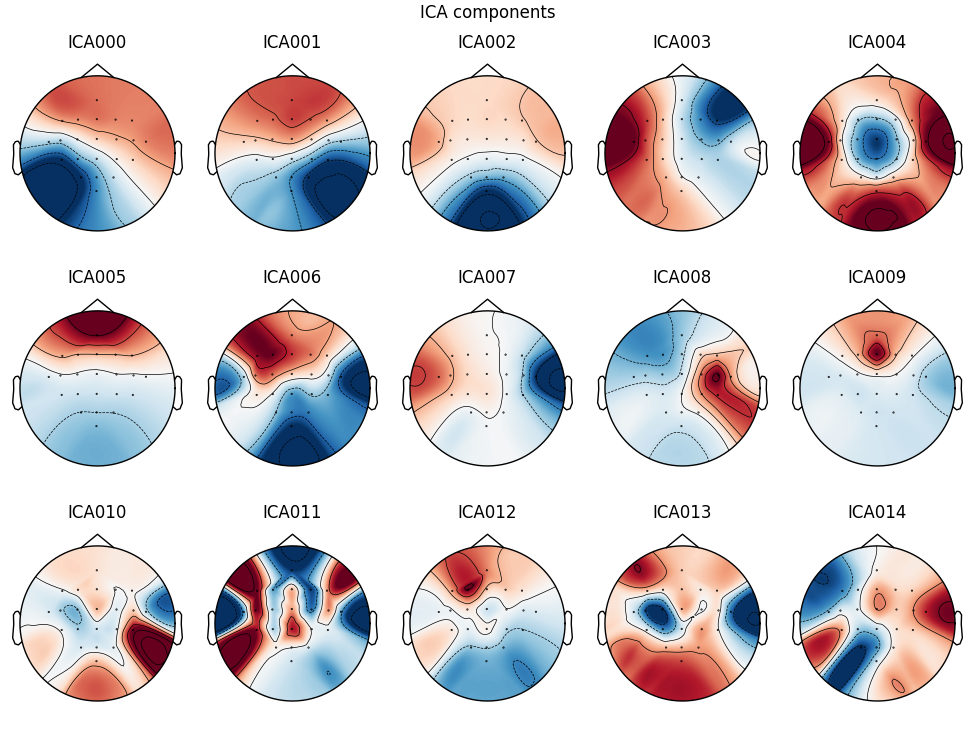

In [21]:
# Plot the ICA components
fig = ica_obj.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


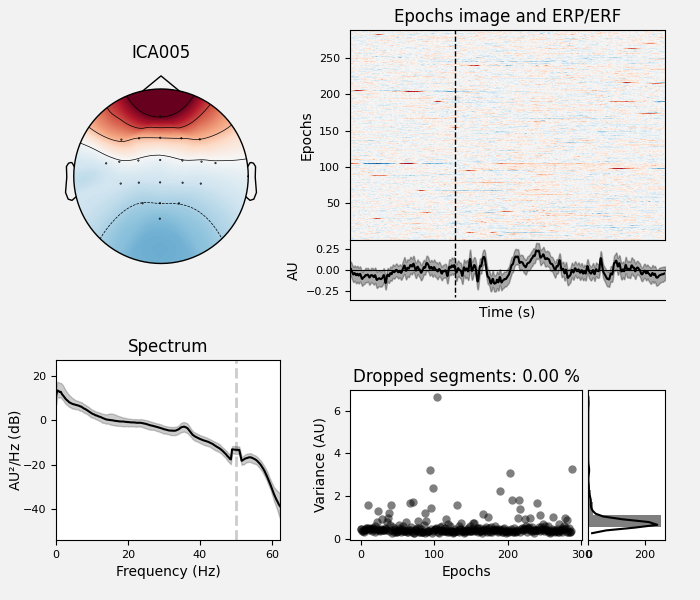

[<Figure size 700x600 with 6 Axes>]

In [22]:
# plot diagnostics
ica_obj.plot_properties(epochs, picks=[5])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


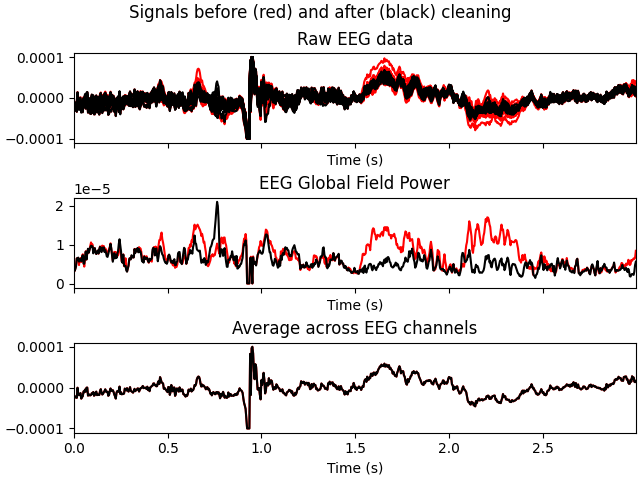

In [23]:
# blinks
fig = ica_obj.plot_overlay(raw, exclude=[5], picks="eeg")

In [24]:
# Drop bad ICA components
ica_obj.exclude = [5]
ica_obj.apply(epochs)

Applying ICA to Epochs instance


    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


/tmp/ipykernel_414855/915559120.py:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica_obj.apply(epochs)


<Epochs |  288 events (all good), -1 – 2 s, baseline -1 – 0 s, ~36.3 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>

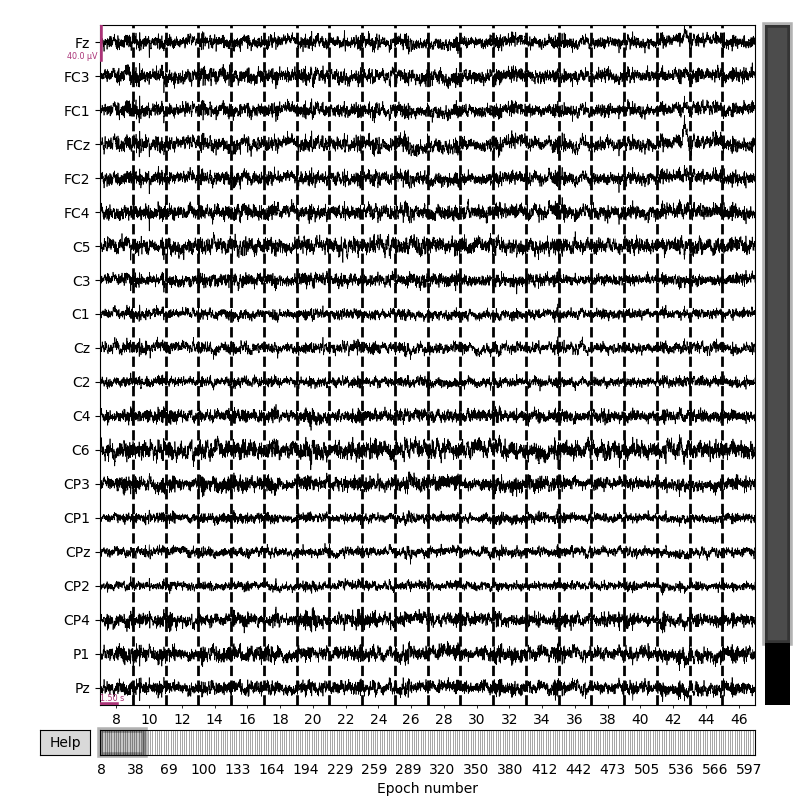

In [25]:
fig = epochs.plot()

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


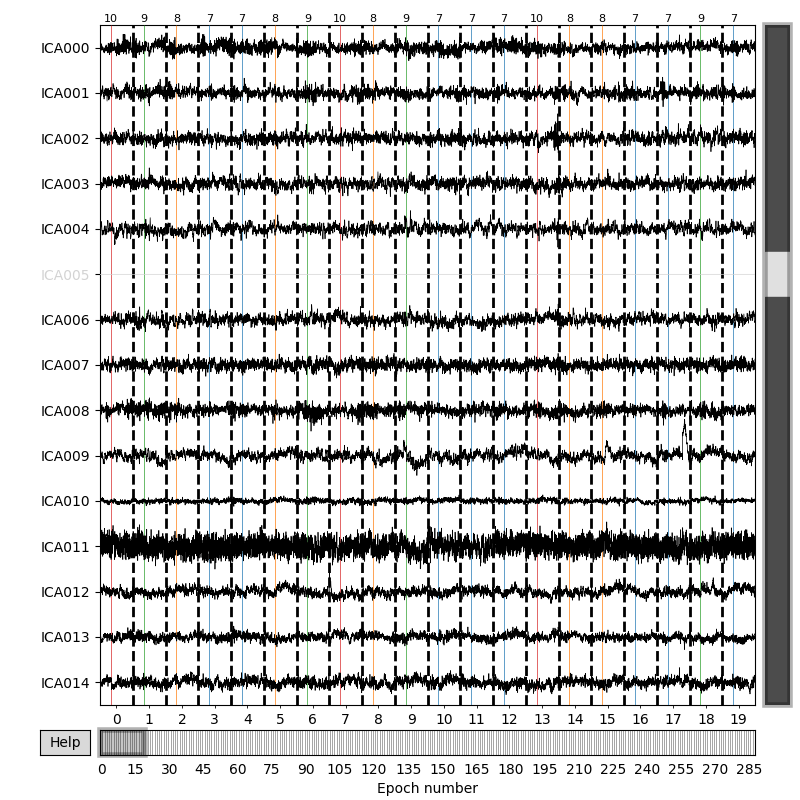

In [26]:
# Plot the ICA scources
fig = ica_obj.plot_sources(epochs)

In [27]:
# Drop bad epochs by observing
epochs.drop([45, 56])

Dropped 2 epochs: 45, 56


<Epochs |  286 events (all good), -1 – 2 s, baseline -1 – 0 s, ~36.1 MB, data loaded,
 '7': 72
 '8': 70
 '9': 72
 '10': 72>

# Feature Analysis

In [193]:
# Get label from processed epochs
labels = epochs.events[:, -1]
labels.shape

(286,)

In [63]:
evoked_1 = epochs['7'].average()
evoked_2 = epochs['8'].average()
evoked_3 = epochs['9'].average()
evoked_4 = epochs['10'].average()
evoked_arr = [evoked_1, evoked_2, evoked_3, evoked_4]

In [115]:
evk_1 = evoked_1.copy().pick(picks=['C3', 'C4', 'Cz'])
evk_2 = evoked_2.copy().pick(picks=['C3', 'C4', 'Cz'])
evk_3 = evoked_3.copy().pick(picks=['C3', 'C4', 'Cz'])
evk_4 = evoked_4.copy().pick(picks=['C3', 'C4', 'Cz'])


In [168]:
data = [evk_1.get_data(), evk_2.get_data(),evk_3.get_data(),evk_4.get_data() ]
ch = ['C3', 'C4', 'Cz']
cls = ['Left', 'Right', 'Feet', 'Tongue']

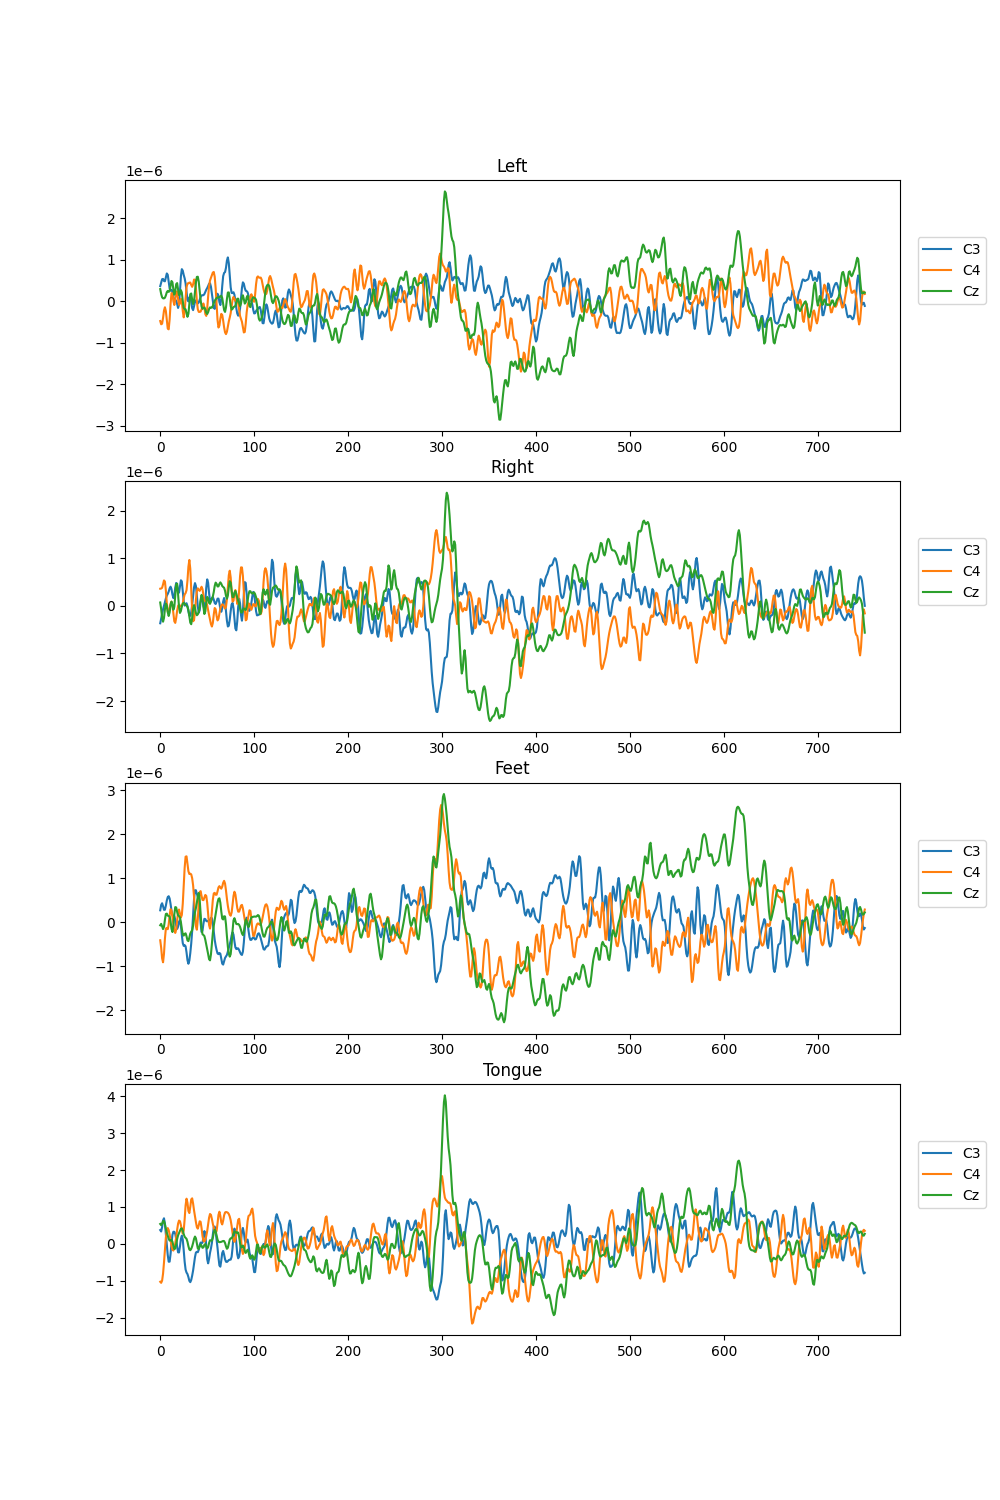

In [140]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

for i in range(len(data)):
    for j in range(len(ch)):
        axes[i].plot(data[i][j], label=ch[j])
    axes[i].set_title(cls[i])
    axes[i].legend(bbox_to_anchor=(1.12, .8))

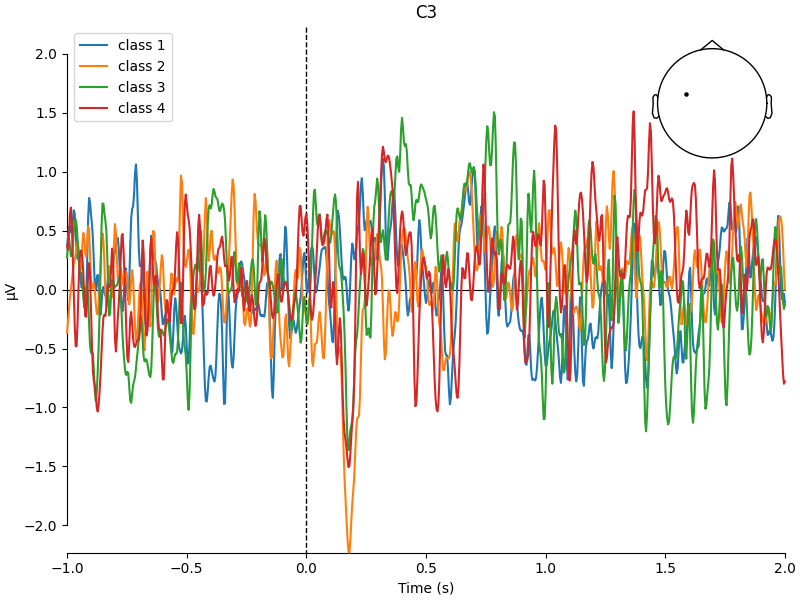

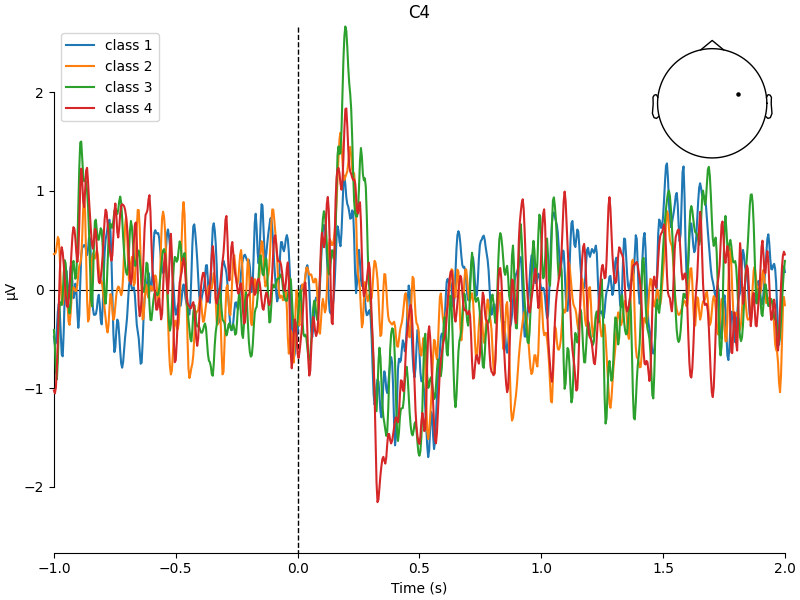

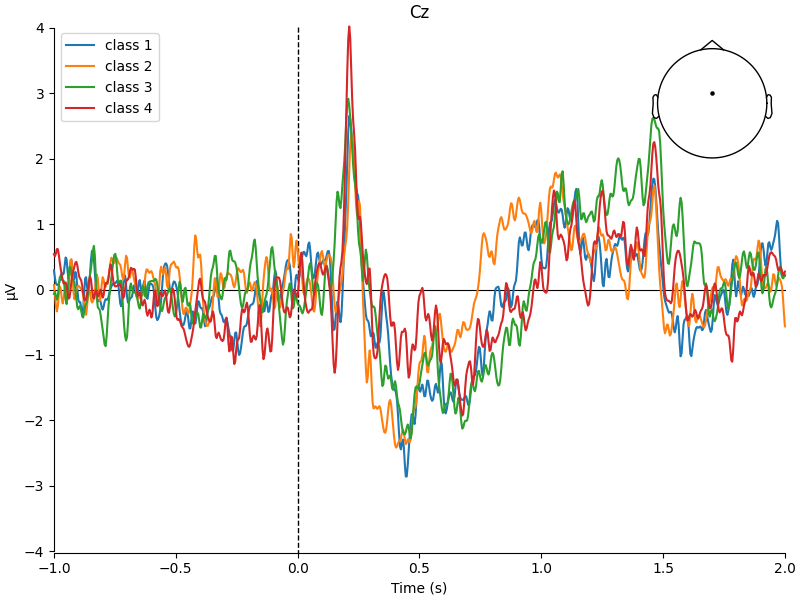

In [151]:
#left,right,foot,tongue
dicts={'class 1':evoked_1,'class 2':evoked_2,'class 3':evoked_3,'class 4':evoked_4}
for i in range(len(ch)):
    mne.viz.plot_compare_evokeds(dicts, picks=ch[i])

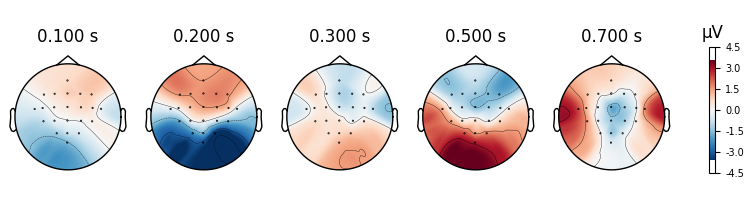

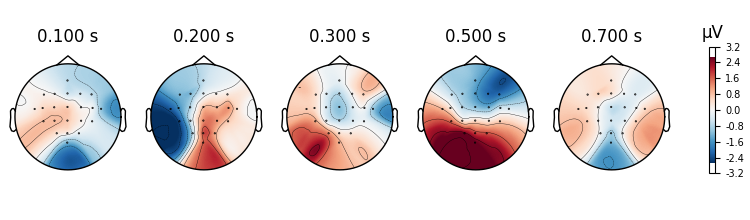

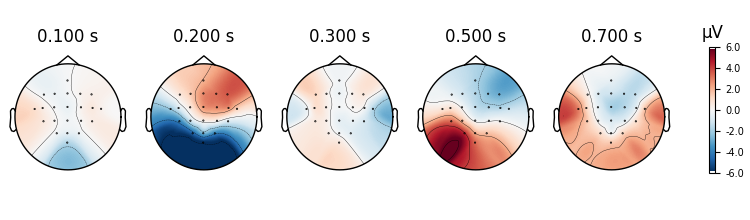

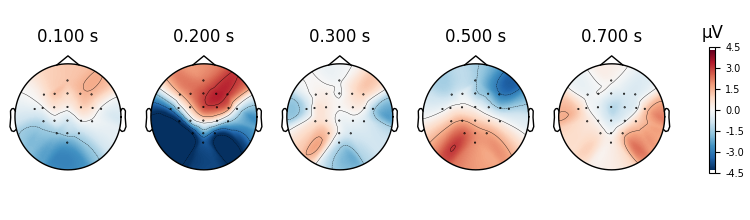

In [121]:
for evoked in evoked_arr:
    fig = evoked.plot_topomap(times=[.1,.2, .3, .5, .7])
    

In [112]:
# for evoked in evoked_arr:
#     fig = evoked.compute_psd().plot_topomap()

In [178]:
# # Define frequency parameters
# freqs = np.arrange(2, 36)  # Define the frequencies of interest (in Hz)
# n_cycles = 5  # Number of cycles for the Morlet wavelet

In [177]:
# for i in range(len(evoked_arr)):
#     for c in ch:
#         # Compute time-frequency representation (TFR)
#         tfr = mne.time_frequency.tfr_morlet(evoked_arr[i].copy().pick(picks=ch), freqs=freqs, n_cycles=freqs, return_itc=False)
#         # Plot power spectral density (PSD)
#         tfr.plot([0], baseline=(None, 0), title=f'{cls[i]} with {c}')

# Feature Extraction

In [180]:
from scipy import signal
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier

In [209]:
from evaluation.evaluation_tools import evaluate_feature

### Statistical Analysis

In [186]:
# A function to extract statistical features from each epoch
def statistical_features(epoch):
    features = []
    
    # Example: Mean, Standard Deviation, Skewness, and Kurtosis
    features.append(np.mean(epoch, axis=1))
    features.append(np.std(epoch, axis=1))
    features.append(stats.skew(epoch, axis=1))
    features.append(stats.kurtosis(epoch, axis=1))
    
    # Add more statistical features as needed
    return np.concatenate(features)

In [ ]:
# Extract features for each epoch
statistical_feature_matrix = np.array([statistical_features(epoch) for epoch in epochs.get_data()])

In [185]:
statistical_feature_matrix.shape

(286, 88)

### CSP (Common Spatial Pattern)

In [211]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from mne.decoding import CSP

In [213]:
csp = CSP(n_components=20, reg=None, log=None, norm_trace=False)

csp_feature_matrix = csp.fit_transform(epochs.get_data(), labels)

Computing rank from data with rank=None


/tmp/ipykernel_414855/533035755.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  csp_feature_matrix = csp.fit_transform(epochs.get_data(), labels)


    Using tolerance 1.3e-05 (2.2e-16 eps * 22 dim * 2.7e+09  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 22 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 22 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.3e-05 (2.2e-16 eps * 22 dim * 2.6e+09  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 22 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 22 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.4e-05 (2.2e-16 eps * 22 dim * 2.9e+09  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 22 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 22 -> 21
Estimating covariance using EMPIRICAL

LinAlgError: SVD did not converge

# Evaluation

### Run with Original data

In [ ]:
features = epochs.get_data().reshape(286, -1)
features.shape

[Result of t-SNE]


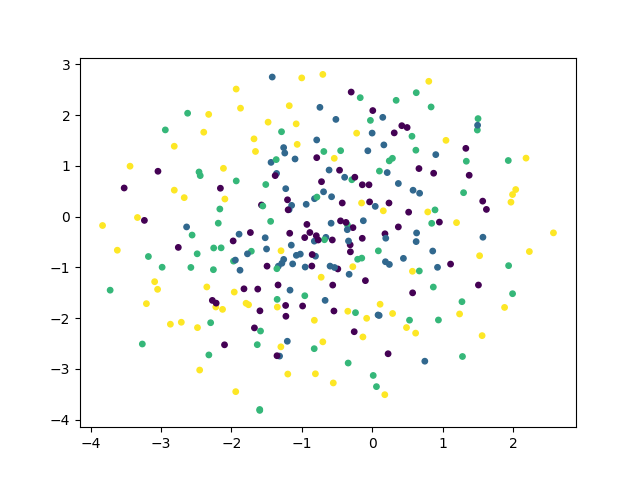

[Result of Random Forest]
Original Data Test Accuracy: 0.45


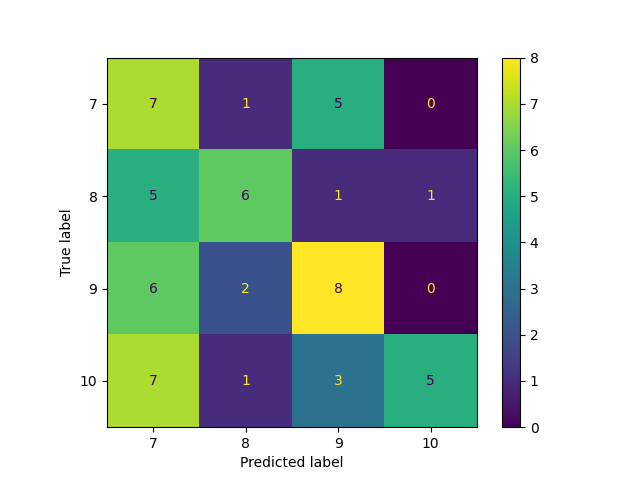

In [210]:
evaluate_feature(features, labels, 'Original Data')

### Run with Statistical Feature 

In [206]:
features_static = statistical_feature_matrix

[Result of t-SNE]


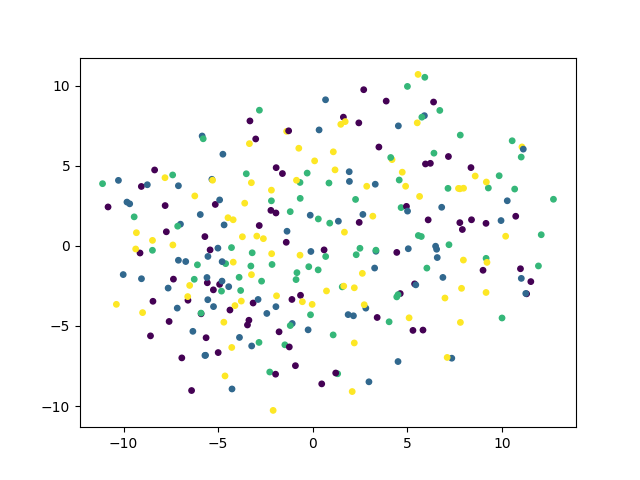

[Result of Random Forest]
Statistical Feature Test Accuracy: 0.36


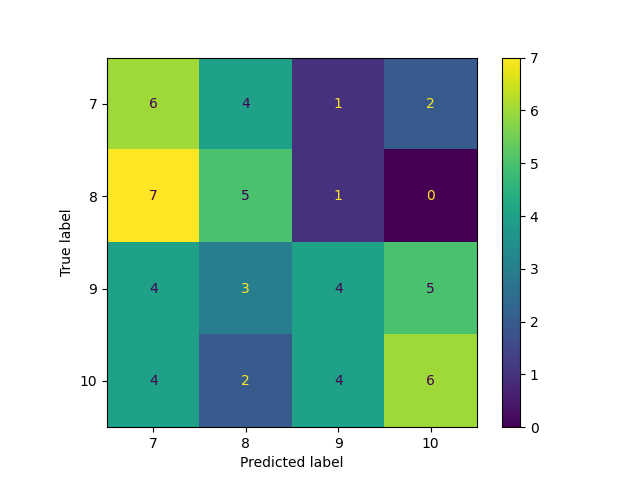

In [207]:
evaluate_feature(features_static, labels, 'Statistical Feature')